In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from datetime import datetime
from scipy import stats
from scipy.stats.stats import pearsonr
import itertools

# 1. Loading Data

In [2]:
data_folder = './pickles/dataframes'

In [3]:
dataset = pd.read_json(data_folder + '/unified_data2.json')

# 2. Initial Analysis

We first want to see the number of recipes in the dataset we have. Our dataset consists of rows representing for each user a review for a certain recipe.

In [4]:
print("Number of unique recipes in the dataset = {}".format(dataset['name'].unique().shape[0]))

Number of unique recipes in the dataset = 15986


## 2.a. Rating distribution

First we would like to inspect how are the users opinions are distributed.

In [5]:
ratings_counts = dict(Counter(dataset['rating'].values))

Text(0.5,1,'Distribution of ratings over the dataset')

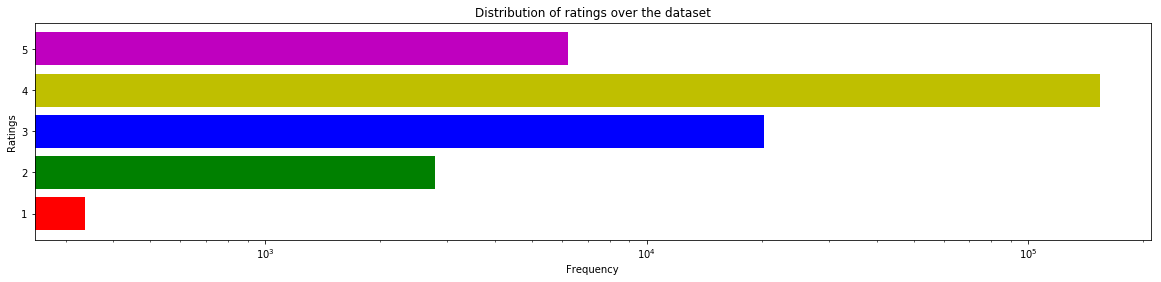

In [6]:
plt.rcParams["figure.figsize"] = (20,4)
plt.barh(ratings_counts.keys(),ratings_counts.values(), align='center',color='rgbym',log=True)
plt.ylabel('Ratings')
plt.xlabel('Frequency')
plt.title('Distribution of ratings over the dataset')

We observe that there is a bias in the dataset, as users tend to love food given by cooks :) <br>
We handle this in our analysis

## 2.b. Distribution of meal sizes

The next step is to observe how the meal sizes are distributed.

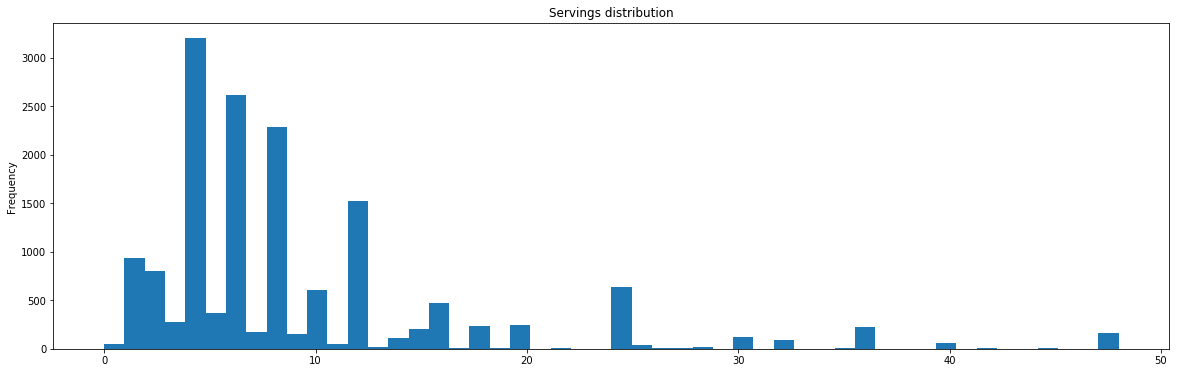

In [7]:
dataset_servings = dataset[['name','servings']]
dataset_servings =  dataset_servings.groupby(['name']).mean().round()
servings = dataset_servings[(dataset_servings['servings'] >= 0) & (dataset_servings['servings'] < 50)]
servings['servings'].plot(kind='hist', bins=50, figsize=(20,6), title='Servings distribution')

From the plot above, we can observe that the recipes are mostly intended for single individuals till 20 people.
Hence mostly the recipes are inteneded for an audience of singles, couples and families. <br>
Some outliers include recipes for events, where the number of people exceeds 20 (this could be weddings or big familly gatherings)

## 2.c. Distribution of reviews over time

The next interesting point to discover if there is a temporal effect on the mood of the people over time.
We now observe the amount of reviews given over time.

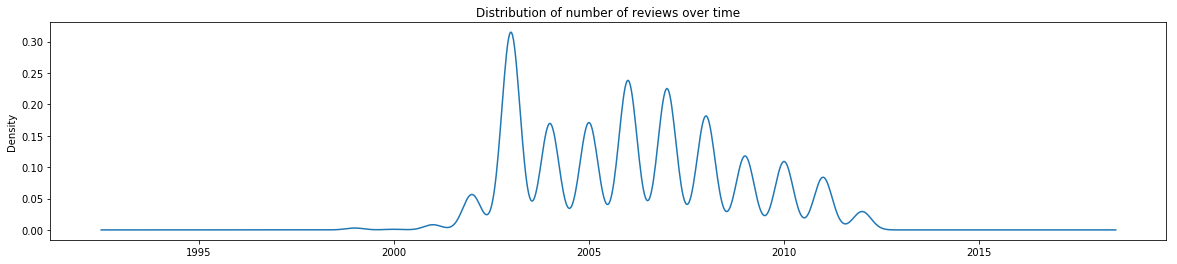

In [8]:
dataset.year.plot.density(title = 'Distribution of number of reviews over time')

It seems that the dataset is quite well distributed over the 10 years starting 2002 till 2010. With a higher number of reviews in 2004.

## 2.d. Nutrition vs Ratings

Now we try to see if nutrition composition of the whole recipe affects the ratings

In [9]:
cols = [ 'name',u'calories', u'cholesterol', u'fat', u'fiber',u'protein', u'sodium', u'totalcarbs', u'rating']
dataset_nutrition = dataset[cols]

In [10]:
dataset_nutrition = dataset_nutrition.groupby(['name']).mean().round()

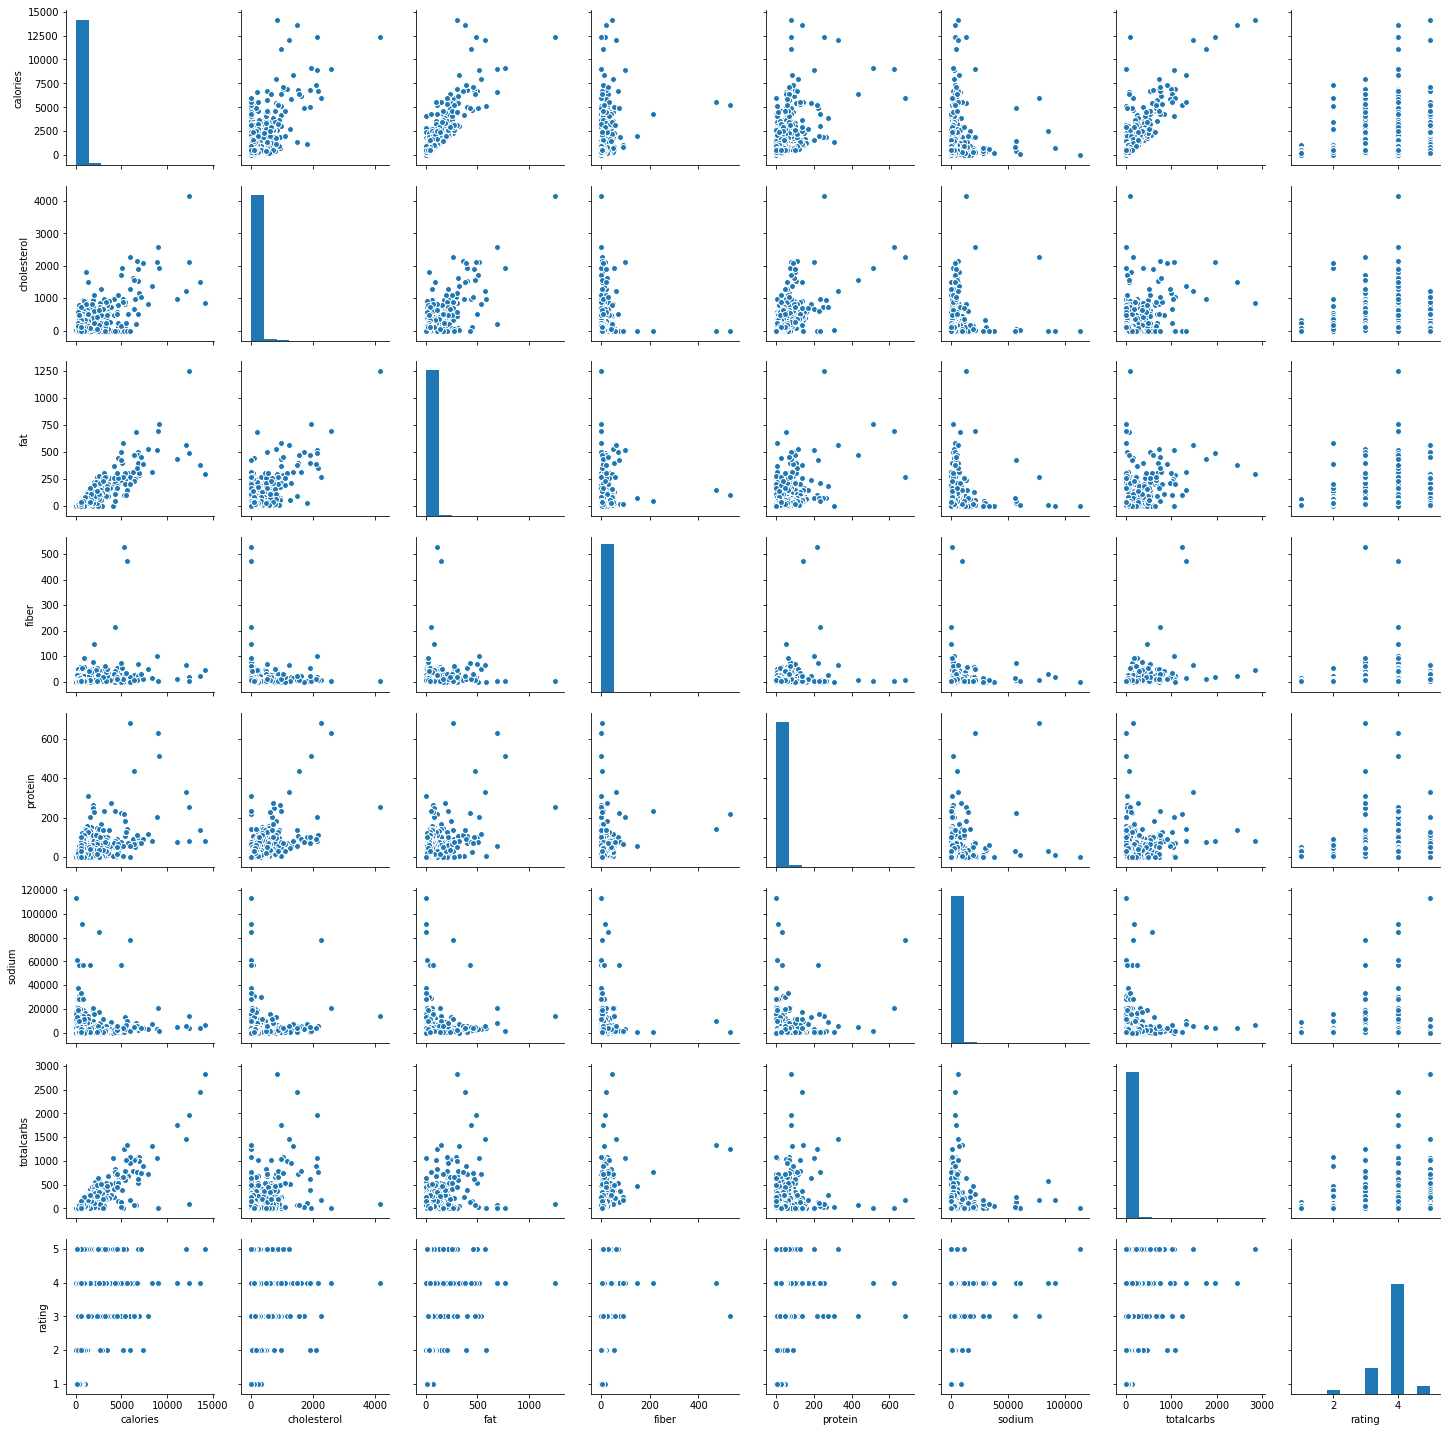

In [11]:
sns.pairplot(dataset_nutrition)

The most relevant row is the last one as it compares each nutrition ingredients. Currently this plot is not informative however we will apply some tricks later in the notebook to extract needed correlations.

## 2.e. Time for preparing and cooking the meal

The second time factor is the preperation and cooking times of the meal. Is it the case that a quick meal is favored or not ? <br>
The first investigation is to see how the meals are distributed over time.

In [12]:
prep_time = dataset.groupby('name').agg({'prep_time':'first'})
cook_time = dataset.groupby('name').agg({'cook_time':'first'})

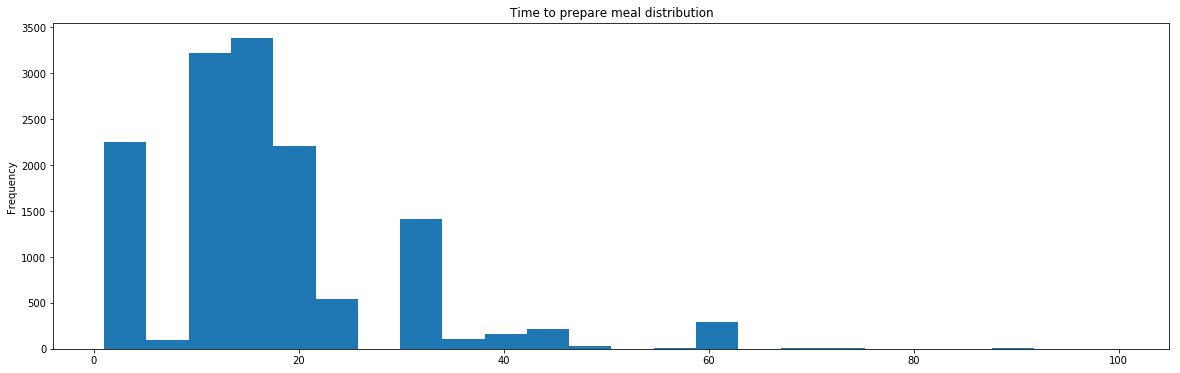

In [13]:
prep_time = prep_time[(prep_time['prep_time'] > 0) & (prep_time['prep_time'] < 120)]
prep_time['prep_time'].plot(kind='hist', bins=24, figsize=(20,6),title='Time to prepare meal distribution')

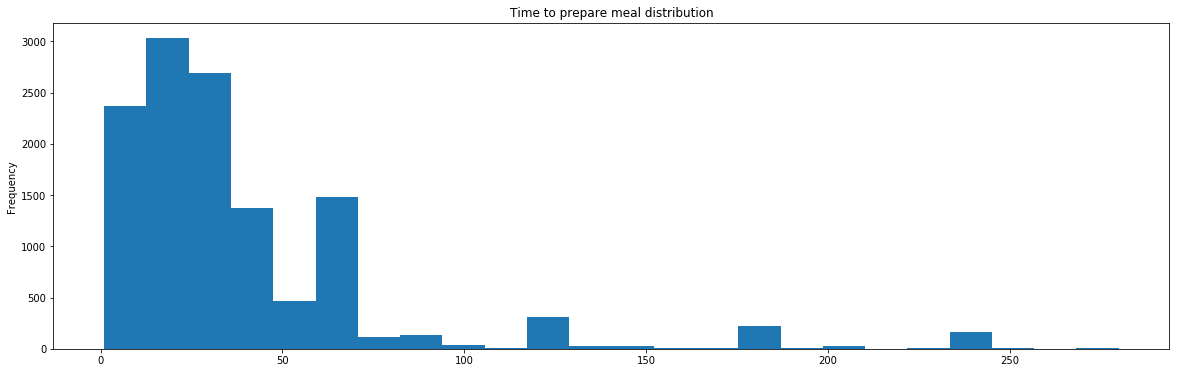

In [14]:
cook_time = cook_time[(cook_time['cook_time'] > 0) & (cook_time['cook_time'] < 300)]
cook_time['cook_time'].plot(kind='hist', bins=24, figsize=(20,6),title='Time to prepare meal distribution')

## 2.f. Foods used

Given the types of foods used , we want to see the best combination of food components to have to have a recipe that gets us a good rating

In [15]:
food_components = dataset.groupby('name').agg({ 'Beans and Rice':'first',
                                                'Cheese and Bread':'first',
                                                'Pasta':'first',
                                                'Pastry':'first',
                                                'Sauces':'first',
                                                'Dipping':'first',
                                                'Spices':'first',
                                                'Herbes':'first',
                                                'Fruits':'first',
                                                'Vegtables':'first',
                                                'Starch':'first',
                                                'Drinks':'first',
                                                'Meat and Chicken':'first',
                                                'Fish':'first',
                                                'Sushi':'first'
                                              
                                              })

/home/omar/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/omar/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/omar/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/omar/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/omar/anaconda2/lib/python2.7/site-pack

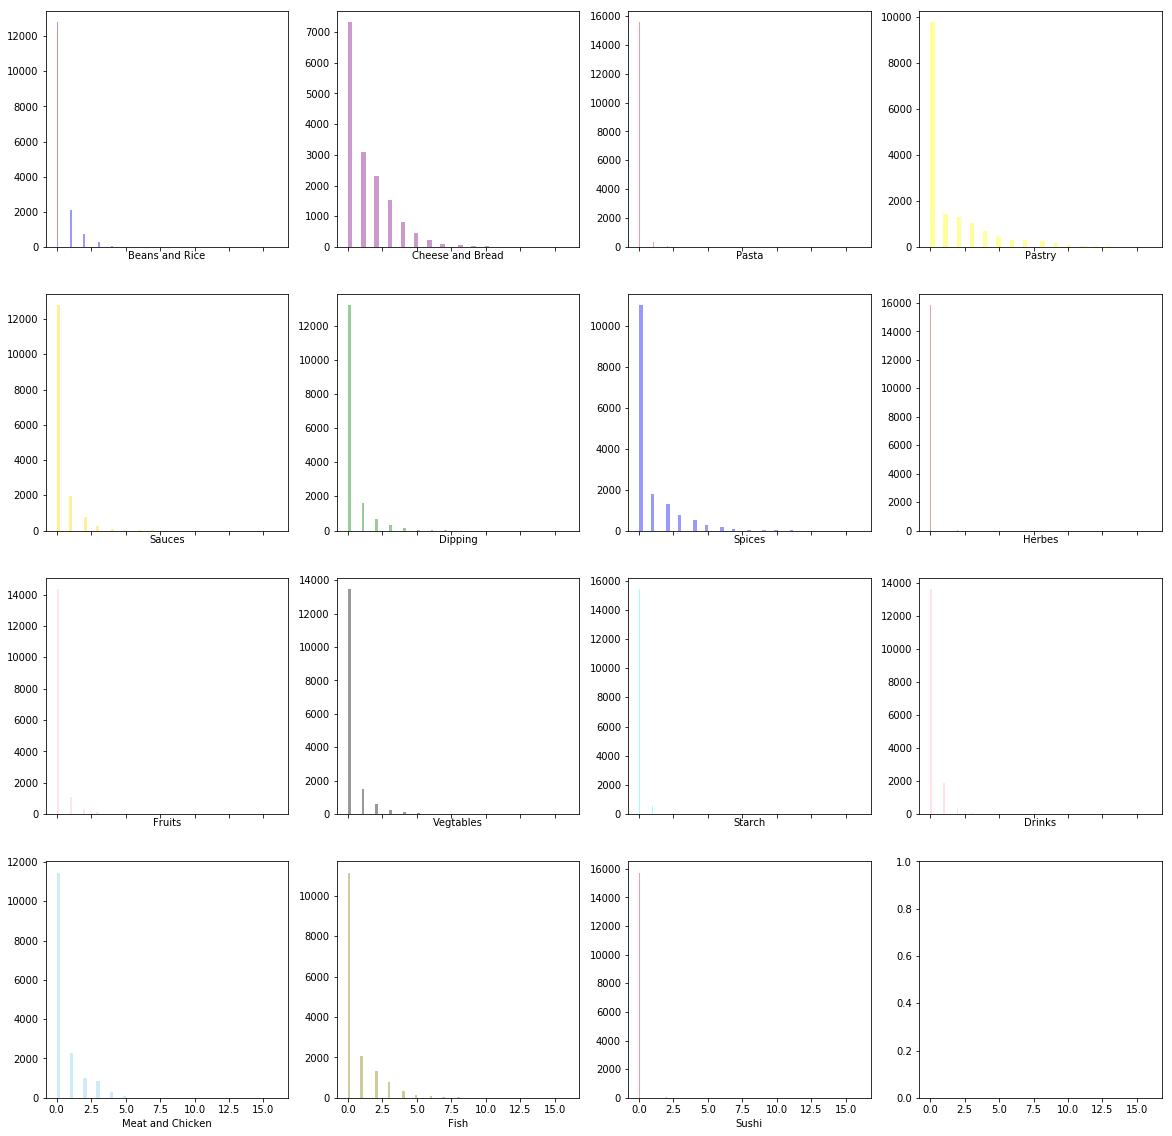

In [16]:
f, axes = plt.subplots(4, 4, figsize=(20,20), sharex=True)

#first row
sns.distplot( food_components['Beans and Rice'] , color="blue", ax=axes[0, 0],kde=False)
sns.distplot( food_components['Cheese and Bread'] , color="purple", ax=axes[0, 1],kde=False)
sns.distplot( food_components['Pasta'] , color="red", ax=axes[0, 2],kde=False)
sns.distplot( food_components['Pastry'] , color="yellow", ax=axes[0, 3],kde=False)

# second row
sns.distplot( food_components['Sauces'] , color="gold", ax=axes[1, 0],kde=False)
sns.distplot( food_components['Dipping'] , color="green", ax=axes[1, 1],kde=False)
sns.distplot( food_components['Spices'] , color="blue", ax=axes[1, 2],kde=False)
sns.distplot( food_components['Herbes'] , color="brown", ax=axes[1, 3],kde=False)


sns.distplot( food_components['Fruits'] , color="pink", ax=axes[2, 0],kde=False)
sns.distplot( food_components['Vegtables'] , color="black", ax=axes[2, 1],kde=False)
sns.distplot( food_components['Starch'] , color="aqua", ax=axes[2, 2],kde=False)
sns.distplot( food_components['Drinks'] , color="lightpink", ax=axes[2, 3],kde=False)


# fourth row

sns.distplot( food_components['Meat and Chicken'] , color="skyblue", ax=axes[3, 0],kde=False)
sns.distplot( food_components['Fish'] , color="olive", ax=axes[3, 1],kde=False)
sns.distplot( food_components['Sushi'] , color="red", ax=axes[3, 2],kde=False)




The plot above has for each food type the number of different components belonging to this clusters that have been used in one recipe.The components are quite well distributed.

## 2.g Summary

The intention of this notebook is to find the factors that affect the having a good rating for a recipe.The factors can be : <br>
1. Meal size
2. Preperation time
3. Cooking time
4. Times of posting the reviews and how the reviews of people are effected by previous review ratings
5. Nutrition composition
6. Food types composition 
7. How would the rating of one recipe effect other recipes

# 3. Factors effecting users sentiment

## 3.a. Observing the effect of cooking and preparation time on users sentiment

To do this type of analysis, we do the following:
1. Compute for each recipe an average of ratings.
2. Keep the value of cooking and preperation times for each recipe.
3. Bucket each time range (as in the bucketing_time function below)
4. Then we compute for each time bucket the number recipes having a rating = y. <br> so for example : recipes that are cooked in less than one hour, we compute number of recipes having rating = 4.

In [17]:
prep_time_data = dataset[['name','prep_time','rating']].copy()
cook_time_data = dataset[['name','cook_time','rating']].copy()

In [18]:
prep_time_data = prep_time_data.groupby('name').agg({'rating':'mean', 'prep_time':'first'})
cook_time_data = cook_time_data.groupby('name').agg({'rating':'mean','cook_time':'first'})
prep_time_data['rating'] = prep_time_data['rating'].round()
cook_time_data['rating'] = cook_time_data['rating'].round()

In [19]:
def bucketing_time(time_point):
    
    if time_point == 0:
        return 'No time'
    elif time_point in range(1,11):
        return 'In ten minutes'
    elif time_point in range(11,60):
        return '< 1hr and > 10 minutes'
    elif time_point in range(60,121):
        return '1hrs > and < 2hrs'
    else:
        return 'more than 2hrs'
    

In [20]:
prep_time_data['prep_time'] = prep_time_data['prep_time'].apply(lambda x: bucketing_time(x))
cook_time_data['cook_time'] = cook_time_data['cook_time'].apply(lambda x: bucketing_time(x))

In [21]:
prep_time_data_temp = prep_time_data.copy().reset_index(drop=True)
cook_time_data_temp = cook_time_data.copy().reset_index(drop=True)

In [22]:
unique_notations = prep_time_data_temp['prep_time'].unique().tolist()

In [23]:
prep_dist = {}
cook_dist = {}

for key in unique_notations:
    
    subset_prep_data = prep_time_data_temp[ prep_time_data_temp.prep_time == key]
    subset_cook_data = cook_time_data_temp[ cook_time_data_temp.cook_time == key]
    
    out_prep = subset_prep_data['rating'].value_counts().to_dict()
    out_cook = subset_cook_data['rating'].value_counts().to_dict()
    
    for i in out_prep.keys():
        if i not in prep_dist:
            prep_dist[i] = {key:out_prep[i]}
        else:
            prep_dist[i][key] = out_prep[i]
            
    for i in out_cook.keys():
        if i not in cook_dist:
            cook_dist[i] = {key:out_cook[i]}
        else:
            cook_dist[i][key] = out_cook[i]

Text(0.5,1,'Recipe Frequency per Prepration time buckets')

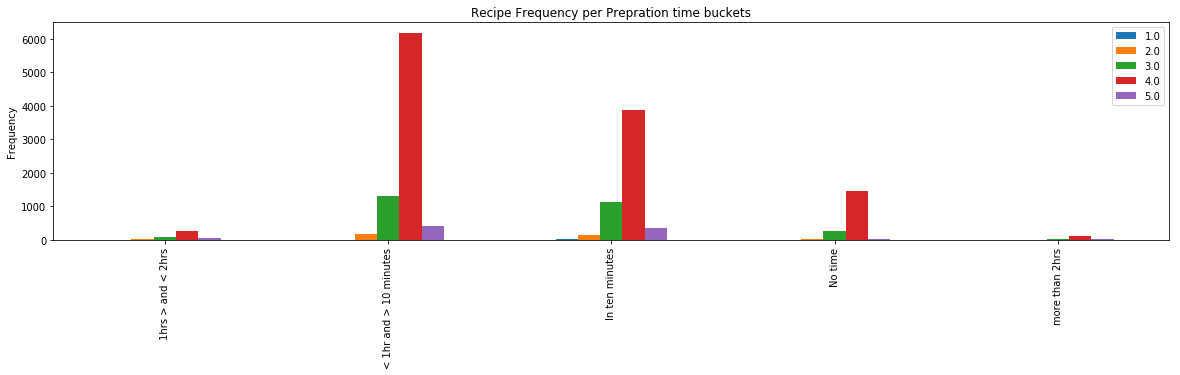

In [26]:
pd.DataFrame(prep_dist).plot.bar()
plt.ylabel('Frequency')
plt.title('Recipe Frequency per Prepration time buckets')

Text(0.5,1,'Recipe Frequency per Cooking time buckets')

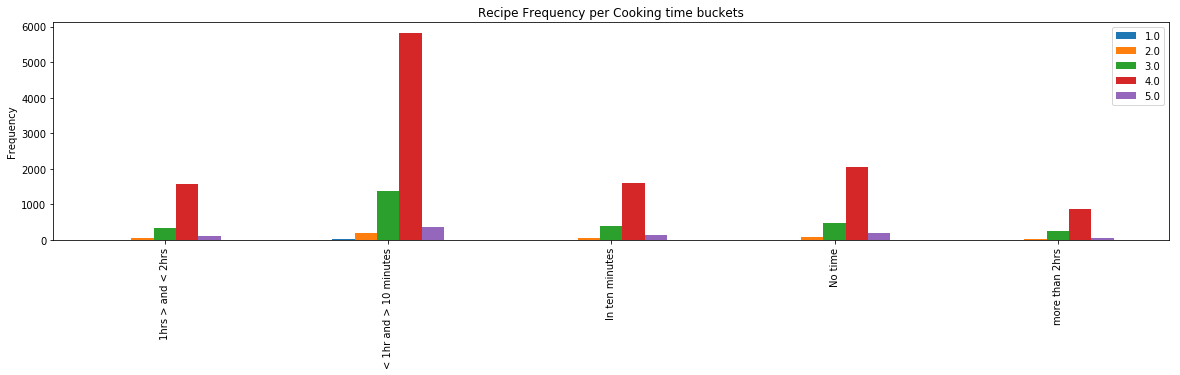

In [27]:
pd.DataFrame(cook_dist).plot.bar()
plt.ylabel('Frequency')
plt.title('Recipe Frequency per Cooking time buckets')

The charts above give us some intution on the correlation between having a recipe with a good rating and cooking and prepration times. There seems to be a tendecy of people liking your recipe if the meal is prepared and cooked between 10 minutes to one hour of time. We will further explore why it is the case when we analyze the combination of these time factors and the amount of people the meal is being cooked for.

## 3.b. Observing the effect of servings size on user sentiment

Now to investigate the effect of meal sizes on the satisfaction of the user with a meal, we have a similar approach as before: <br>
1. We compute for each recipe an average rating of all users
2. We transform meal sizes as buckets (check bucketin_meal_sizes function)
3. For each meal size we compute the number of recipes rated x by users

In [28]:
servings_data = dataset[['name','servings','rating']].copy()

In [29]:
servings_data = servings_data.groupby('name').agg({'rating':'mean', 'servings':'first'})
servings_data['rating'] = servings_data['rating'].round()

In [30]:
def bucketing_meal_sizes(meal_size):
    
    if meal_size == 1:
        return 'individual'
    elif meal_size == 2:
        return 'couple'
    elif meal_size in range(3,10):
        return 'family'
    elif meal_size in range(11,30):
        return 'Big family'
    else:
        return 'Event'    

In [31]:
servings_data['servings'] = servings_data['servings'].apply(lambda x: bucketing_meal_sizes(x))

In [32]:
servings_data_temp = servings_data.copy().reset_index(drop=True)

In [33]:
unique_notations = servings_data['servings'].unique().tolist()

In [34]:
serving_dist = {}

for key in unique_notations:
    
    subset_serving_data = servings_data_temp[ servings_data_temp.servings == key]
    
    out = subset_serving_data['rating'].value_counts().to_dict()
    
    for i in out.keys():
        if i not in serving_dist:
            serving_dist[i] = {key:out[i]}
        else:
            serving_dist[i][key] = out[i]

Text(0.5,1,'Meal sizes rating frequencies')

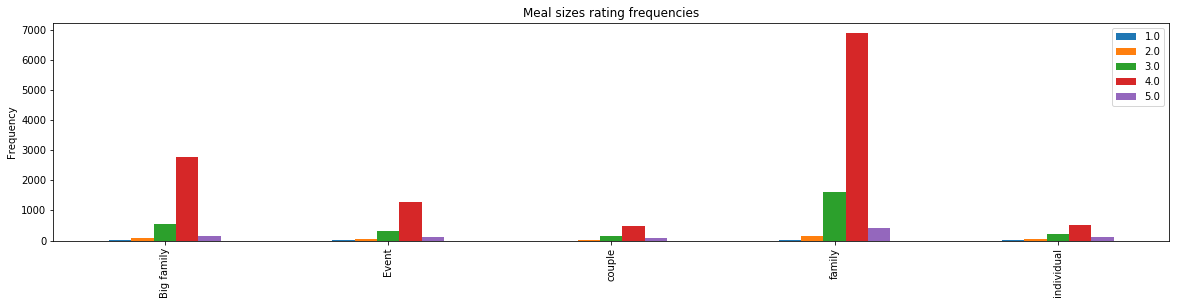

In [36]:
pd.DataFrame(serving_dist).plot.bar()
plt.ylabel('Frequency')
plt.title('Meal sizes rating frequencies')

The plot above indicates that most recipes are favoured by a large amount of people. This can be contributed to the fact that most gatherings include food and thus people tend to look recipes up and try them out !!!

## 3.c. Combining the meal size and time to prepare the meals

Prepration and Cooking times and meal sizes give us good indicators on how to have a successfull recipe. However maybe their combination can give us a better intuition on what is happening. The approach of this analysis:
1. Combine all previous dataframes by recipe name
2. Compute for each combination the frequencies as above

In [37]:
combined_sets = pd.concat([servings_data,prep_time_data[['prep_time']],cook_time_data[['cook_time']]], axis=1, join_axes=[servings.index])

In [38]:
combined_sets.head()

,rating,servings,prep_time,cook_time
name,,,,
""" Ant"" Kelly's London Broil Marinade",5.0,family,< 1hr and > 10 minutes,more than 2hrs
""" Creamy "" Vegan Potato-Leek Soup",3.0,family,< 1hr and > 10 minutes,< 1hr and > 10 minutes
""" Da Best"" Chicago-Style Italian Beef",4.0,family,more than 2hrs,1hrs > and < 2hrs
""" Healthy"" Pumpkin Pie",4.0,family,In ten minutes,1hrs > and < 2hrs
""" Jamba Juice at Home"" Strawberries Wild Smoothie",5.0,family,No time,In ten minutes


In [39]:
meal_size_un,prep_time_un = (np.unique(combined_sets['servings'].values)).tolist(),np.unique(combined_sets['prep_time'].values).tolist()

In [40]:
combinations = [(a,b) for a in meal_size_un for b in prep_time_un]

In [41]:
result_dict = {}
for comb in combinations:
    subset_data = combined_sets[ (combined_sets.servings==comb[0]) & (combined_sets.prep_time == comb[1]) ]
    rating_counts = subset_data.rating.value_counts()
    
    key = comb[0] + ' and ' + comb[1]
    
    for i in rating_counts.keys():
        if i not in result_dict:
            result_dict[i] = {key:rating_counts[i]}
        else:
            result_dict[i][key] = rating_counts[i]

In [51]:
meal_size_un,cook_time_un = (np.unique(combined_sets['servings'].values)).tolist(),np.unique(combined_sets['cook_time'].values).tolist()

In [52]:
combinations_cook = [(a,b) for a in meal_size_un for b in cook_time_un]

In [56]:
result_dict_cook = {}
for comb in combinations_cook:
    subset_data = combined_sets[ (combined_sets.servings==comb[0]) & (combined_sets.cook_time == comb[1]) ]
    rating_counts = subset_data.rating.value_counts()
    
    key = comb[0] + ' and ' + comb[1]
    
    for i in rating_counts.keys():
        if i not in result_dict_cook:
            result_dict_cook[i] = {key:rating_counts[i]}
        else:
            result_dict_cook[i][key] = rating_counts[i]

Text(0.5,1,'Combination of Preperation time and Meal Sizes against Rating Frequency')

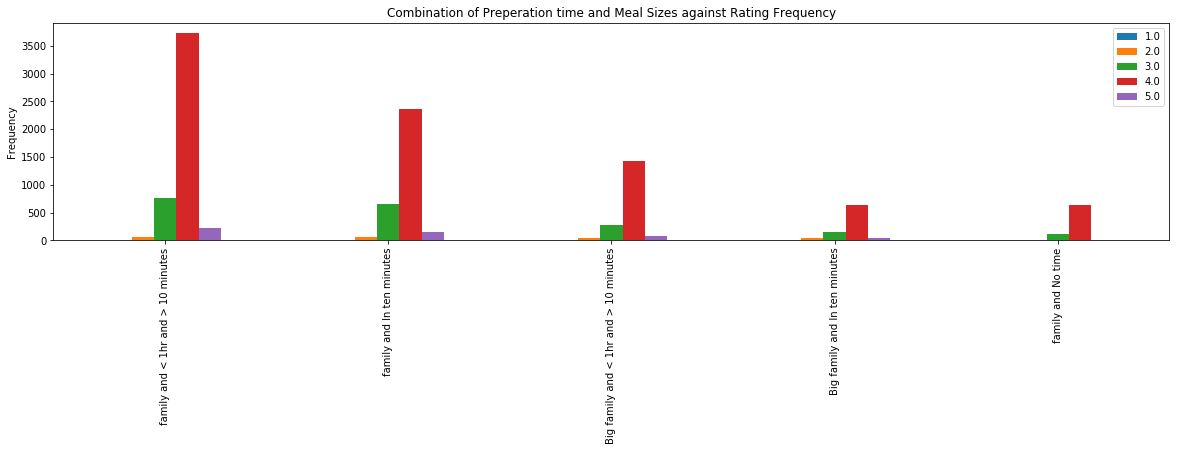

In [50]:
pd.DataFrame(result_dict).sort_values(4,ascending=False).head(5).plot.bar()
plt.ylabel('Frequency')
plt.title('Combination of Preperation time and Meal Sizes against Rating Frequency')

Text(0.5,1,'Combination of Cooking time and Meal Sizes against Rating Frequency')

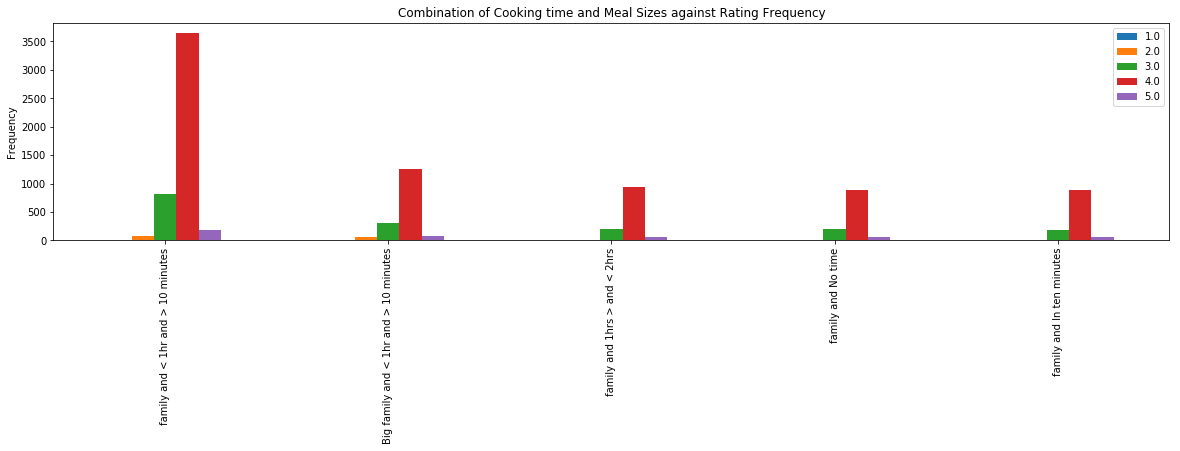

In [57]:
pd.DataFrame(result_dict_cook).sort_values(4,ascending=False).head(5).plot.bar()
plt.ylabel('Frequency')
plt.title('Combination of Cooking time and Meal Sizes against Rating Frequency')

The plot above certifies our claims before. Preperation and  Cooking in a small amount and targeting families should give the recipe and advantage when it's posted online. 

## 3.d. Viewing how the composition of ingredients effects the rating

In this section we would like to investigate how the different combinations of food components is enough to give us a good rating.

The first attempt is to see if there is a direct correlation between the number of food elements used and the rating of the recipe. We start by keeping the rows having a recipe per row

In [58]:
food_cols = ['Beans and Rice','Cheese and Bread','Dipping','Drinks','Fish','Fruits','Herbes','Meat and Chicken', 'Pasta', 'Pastry','Sauces','Spices','Starch','Vegtables']

In [59]:
food_cols_data = (dataset[['name','rating'] + food_cols]).copy()
food_cols_data = food_cols_data.groupby('name').agg({'Beans and Rice': 'first',
                                                     'Cheese and Bread': 'first',
                                                     'Dipping': 'first',
                                                     'Drinks': 'first',
                                                     'Fish': 'first',
                                                     'Fruits': 'first',
                                                     'Herbes': 'first',
                                                     'Meat and Chicken': 'first', 
                                                     'Pasta': 'first',
                                                     'Pastry': 'first',
                                                     'Sauces': 'first',
                                                     'Spices': 'first',
                                                     'Starch': 'first',
                                                     'Vegtables':'first',
                                                     'rating':'mean'
                                                    })
food_cols_data['rating'] = food_cols_data['rating'].round()

In [60]:
food_cols_data.head()

,rating,Cheese and Bread,Meat and Chicken,Dipping,Herbes,Fruits,Spices,Beans and Rice,Vegtables,Starch,Fish,Pastry,Pasta,Sauces,Drinks
name,,,,,,,,,,,,,,,
""" Ant"" Kelly's London Broil Marinade",5.0,0,2,0,0,0,3,0,0,0,0,1,0,3,0
""" Creamy "" Vegan Potato-Leek Soup",3.0,0,1,0,0,0,2,0,4,0,0,0,0,0,0
""" Da Best"" Chicago-Style Italian Beef",4.0,0,2,0,0,0,2,0,0,0,0,1,0,0,0
""" Healthy"" Pumpkin Pie",4.0,0,0,0,0,2,1,0,0,0,0,7,0,0,0
""" Jamba Juice at Home"" Strawberries Wild Smoothie",5.0,0,0,0,0,2,0,0,0,0,0,0,0,0,0


In [61]:
correlations = food_cols_data.corr()['rating']

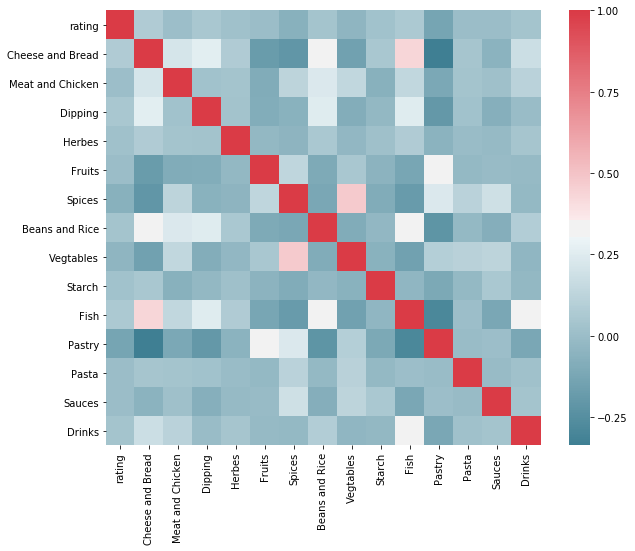

In [63]:
f, ax = plt.subplots(figsize=(10, 8))
corr = food_cols_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True,ax=ax)

We observe the correlation factors above and we observe they are quite minimal. We will use the trick of bucketing to better represent our data.<br>
The components used are split into:
1. Not used : a food type which has 0 elements
2. Moderate use : a food type which is used between 1 and 6 different types. Example: using both chicken and meat in one recipe we get for the column meats a count of 2; which is moderate.
3. Extensive use : is using the same food elements of one cluster many times. Example : Using 7 different types of fruits in one recipe

In [64]:
def bucket_food_category(food_type):
    
    if food_type == 0:
        return 'Not Used'
    elif food_type in range(1,6):
        return 'Moderate Use'
    else:
        return 'Extensive Use'

In [65]:
for i in range(0,len(food_cols)):
    food_cols_data[food_cols[i]] = food_cols_data[food_cols[i]].apply(lambda x : bucket_food_category(x))

In [66]:
food_cols_data.head()

,rating,Cheese and Bread,Meat and Chicken,Dipping,Herbes,Fruits,Spices,Beans and Rice,Vegtables,Starch,Fish,Pastry,Pasta,Sauces,Drinks
name,,,,,,,,,,,,,,,
""" Ant"" Kelly's London Broil Marinade",5.0,Not Used,Moderate Use,Not Used,Not Used,Not Used,Moderate Use,Not Used,Not Used,Not Used,Not Used,Moderate Use,Not Used,Moderate Use,Not Used
""" Creamy "" Vegan Potato-Leek Soup",3.0,Not Used,Moderate Use,Not Used,Not Used,Not Used,Moderate Use,Not Used,Moderate Use,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used
""" Da Best"" Chicago-Style Italian Beef",4.0,Not Used,Moderate Use,Not Used,Not Used,Not Used,Moderate Use,Not Used,Not Used,Not Used,Not Used,Moderate Use,Not Used,Not Used,Not Used
""" Healthy"" Pumpkin Pie",4.0,Not Used,Not Used,Not Used,Not Used,Moderate Use,Moderate Use,Not Used,Not Used,Not Used,Not Used,Extensive Use,Not Used,Not Used,Not Used
""" Jamba Juice at Home"" Strawberries Wild Smoothie",5.0,Not Used,Not Used,Not Used,Not Used,Moderate Use,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used


In [67]:
test = {}
cols = food_cols_data.columns.values.tolist()
check = ['Not Used','Moderate Use','Extensive Use']

for col in cols[1:]:
    
    for val in check:
    
        subset_food = food_cols_data[ food_cols_data[col] == val]
        subset_food = subset_food[[col,'rating']]
        subset_count = subset_food['rating'].value_counts().to_dict()
        
        for i in range(1,6):
            if i not in subset_count:
                subset_count[i] = 0
        
        
        if val not in test:
            test[val] = {col:subset_count}
        else:
            test[val][col] = subset_count

In [68]:
check = []
for key in test.keys():
    check.append(pd.DataFrame(test[key]).T)

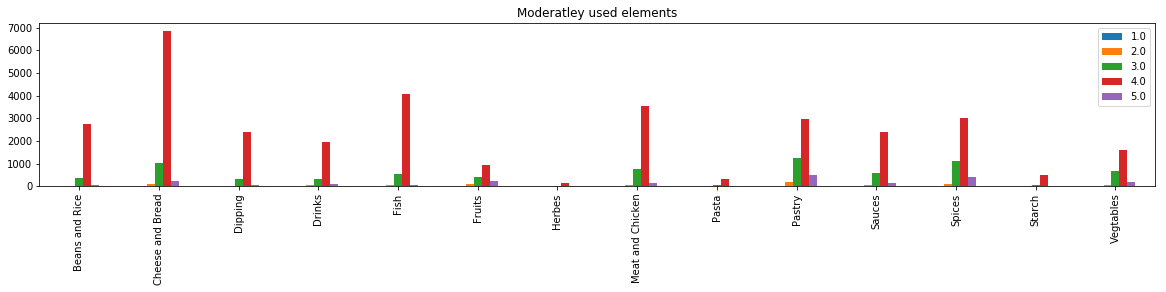

In [69]:
plt.rcParams["figure.figsize"] = (20,3)
check[0].plot.bar(title='Moderatley used elements')

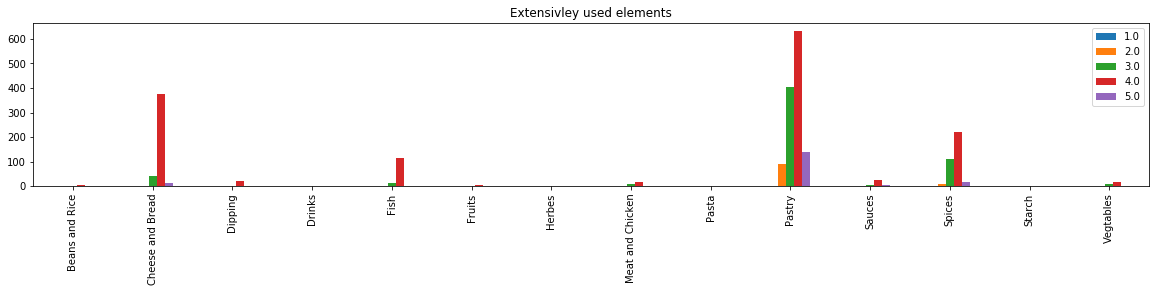

In [70]:
plt.rcParams["figure.figsize"] = (20,3)
check[1].plot.bar(title = 'Extensivley used elements')

In the plots above we directly find the relation between the use of one food type and the rating of recipes having these components. For moderate use of food types is quite well distributed between all food types. However extensive use of these elements in recipes informs us that cheeses nd bread / pastry / spices are frequent with good reviews.

The next step is to find the best combinations of these food types to give a good rating.We first start by computing all combinations of food types existing in our dataset

In [71]:
# compute a dataframe having all food types
comb_df = food_cols_data.copy()
comb_df = comb_df[comb_df.columns[1:]]
comb_df = comb_df.reset_index()
comb_df = comb_df.drop('name',axis=1)

In [72]:
comb_df.head()

,Cheese and Bread,Meat and Chicken,Dipping,Herbes,Fruits,Spices,Beans and Rice,Vegtables,Starch,Fish,Pastry,Pasta,Sauces,Drinks
0,Not Used,Moderate Use,Not Used,Not Used,Not Used,Moderate Use,Not Used,Not Used,Not Used,Not Used,Moderate Use,Not Used,Moderate Use,Not Used
1,Not Used,Moderate Use,Not Used,Not Used,Not Used,Moderate Use,Not Used,Moderate Use,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used
2,Not Used,Moderate Use,Not Used,Not Used,Not Used,Moderate Use,Not Used,Not Used,Not Used,Not Used,Moderate Use,Not Used,Not Used,Not Used
3,Not Used,Not Used,Not Used,Not Used,Moderate Use,Moderate Use,Not Used,Not Used,Not Used,Not Used,Extensive Use,Not Used,Not Used,Not Used
4,Not Used,Not Used,Not Used,Not Used,Moderate Use,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used,Not Used


In [73]:
cols = comb_df.columns.values.tolist()

In [74]:
temp_comb = comb_df.drop_duplicates().values.tolist() # all possible combinations of food types in the dataset

In [75]:
result_dict = {}
for i in range(0,len(temp_comb)): # iterate over all combinations
    
    combination = temp_comb[i]
    
    # subset the data keeping only the needed combination
    condition = (food_cols_data[cols[0]] == combination[0] ) 
    for i in range(1,len(cols[1:])+1):
        condition = condition & (food_cols_data[cols[i]]  == combination[i])
    
    subset_combination = food_cols_data[condition]
    rating_distribution = subset_combination['rating'].value_counts().to_dict() # compute rating distribution
    
    result_dict[tuple(combination)] = rating_distribution

In [76]:
best_comb = pd.DataFrame(result_dict).T
best_comb = best_comb.fillna(0)
best_comb = best_comb.sort_values(by=[4,5],ascending=False)

In [77]:
best_comb.head()

1.0  \
Moderate Use Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  4.0   
Not Used     Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  2.0   
Moderate Use Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Moderate Use Not Used  0.0   
                                                                                     Moderate Use Not Used     Not Used Not Used     Not Used  0.0   
Not Used     Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Moderate Use Not Used Not Used     Not Used  1.0   

                                                                                                                                                2.0  \
Moderate Use Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  17.0   
Not Used     Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  18.0   
Moderate Use Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Moderate Use Not Used   4.0   
                                                                                     Moderate Use Not Used     Not Used Not Used     Not Used   3.0   
Not Used     Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Moderate Use Not Used Not Used     Not Used  49.0   

                                                                                                                                                 3.0  \
Moderate Use Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  108.0   
Not Used     Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  116.0   
Moderate Use Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Moderate Use Not Used   41.0   
                                                                                     Moderate Use Not Used     Not Used Not Used     Not Used   45.0   
Not Used     Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Moderate Use Not Used Not Used     Not Used  166.0   

                                                                                                                                                 4.0  \
Moderate Use Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  824.0   
Not Used     Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  637.0   
Moderate Use Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Moderate Use Not Used  377.0   
                                                                                     Moderate Use Not Used     Not Used Not Used     Not Used  319.0   
Not Used     Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Moderate Use Not Used Not Used     Not Used  309.0   

                                                                                                                                                5.0  
Moderate Use Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  17.0  
Not Used     Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used Not Used     Not Used     Not Used Not Used     Not Used  24.0  
Moderate Use Not Used Not Used Not Used Not Used Not Used N

In [112]:
y_check = best_comb.copy().reset_index().iloc[2:6].values.tolist() # keep top ten combinations

In [113]:
# change the results to format them
top_five_combinations = {}
for i in range(0,len(y_check)):
    comb = y_check[i]
    food_amounts = comb[0:len(comb)-5]
    ratings = comb[-5:]
    res = ""
    for j in range(0,len(cols)):
        use_name = cols[j] + ' (' + food_amounts[j] + ')'
        if food_amounts[j] !='Not Used':
            if res == "":
                res = use_name + '\n'
            else:
                res = res + ' and ' + use_name + '\n'
    top_five_combinations[res] =  {4:comb[-2],5:comb[-1]}

In [114]:
plots = pd.DataFrame(top_five_combinations).T

In [115]:
plots = plots.sort_values(4,ascending=False)

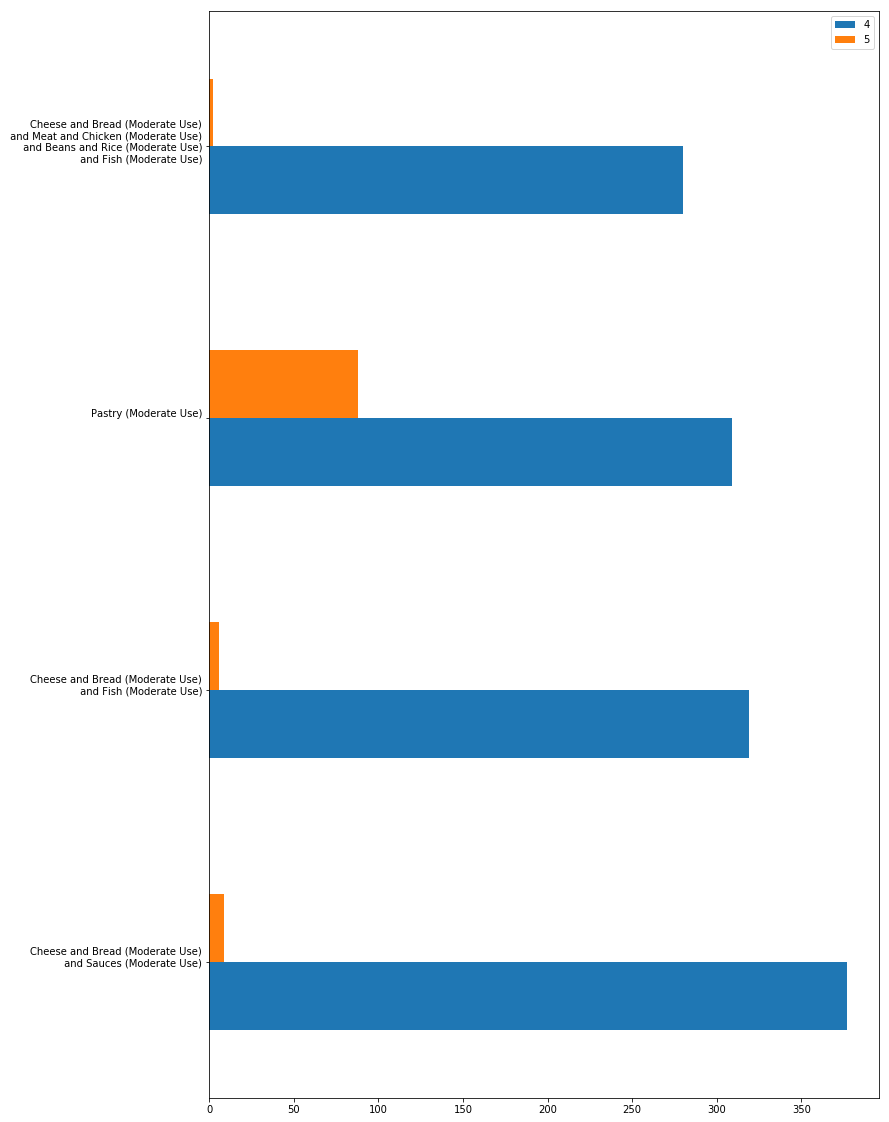

In [116]:
plt.rcParams["figure.figsize"] = (12,20)
plots.plot.barh()

It seems that the best combination of fodd types is to have a moderate amount of cheeses and bread with moderate amounts of sauces. The next combination is moderate use of fish with bread and cheeses. Then in 3rd place comes the moderate use of pastry. 

## 3.e. Studying ratings against time factor

Now we would like to inspect the mood of users over time and see the effect of on initial review by the user on later in time.

We start by selecting the five most reviewed recipes.

In [122]:
# selet topmost 5 recipes
unique_recipes = dataset.groupby('name').agg({'rating':'count'})
most_reviewed_recipes = unique_recipes.sort_values(by=['rating'],ascending=False)

In [123]:
most_reviewed_recipes = most_reviewed_recipes.take([0,1,2,3])

In [124]:
most_reviewed_recipes = most_reviewed_recipes.reset_index()

In [125]:
reviewed_names = most_reviewed_recipes['name'].unique()

In [126]:
top_five_recipes = []
for name in reviewed_names:
    top_five_recipes.append(dataset[dataset.name == name])

In [127]:
top_five_recipes = pd.concat(top_five_recipes) # construct the top_Five most dataframe

In [128]:
# convert the date features into datetime object
top_five_recipes = top_five_recipes[['name','day','month','year','rating']]

In [129]:
date_info = list(zip(top_five_recipes['day'].values.tolist(),top_five_recipes['month'].values.tolist(),top_five_recipes['year'].values.tolist()))
date_info = list(map(lambda x : datetime(x[2],x[1],x[0]),date_info))

In [130]:
top_five_recipes['date'] = date_info

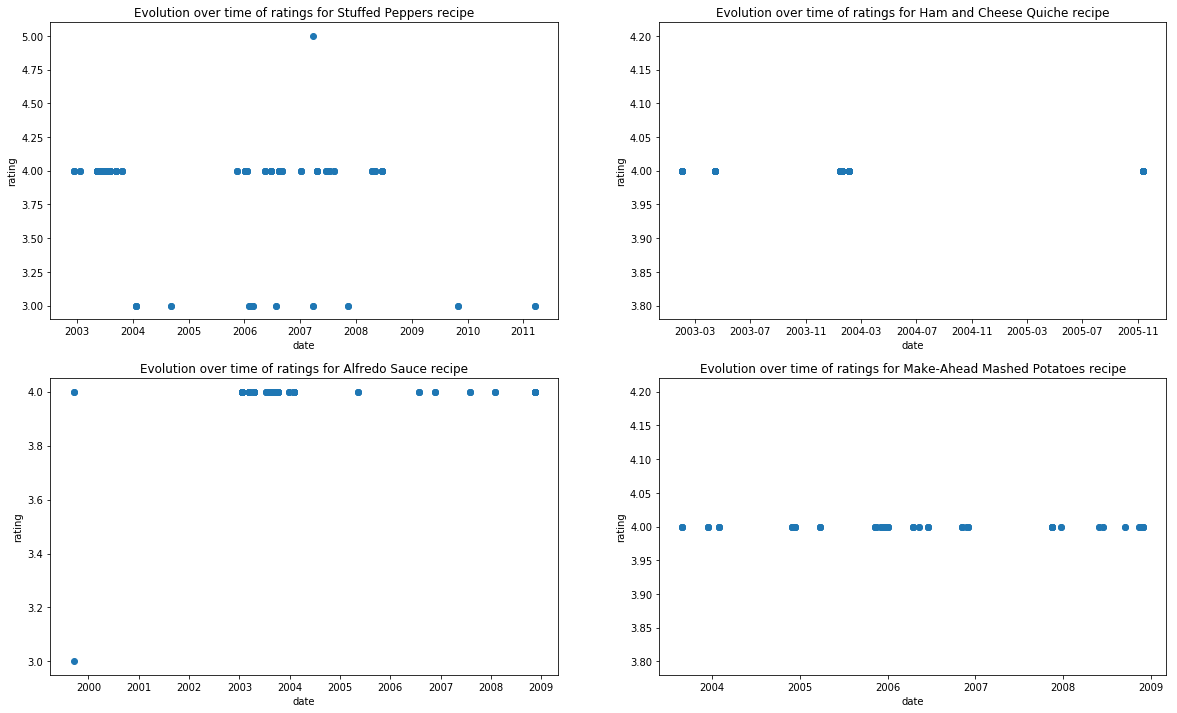

In [140]:
plt.rcParams["figure.figsize"] = (20,12)
i = 1
for name in reviewed_names:
    subset_data = top_five_recipes[top_five_recipes['name'] == name]
    subset_data = subset_data[['date','rating']]
    plt.subplot(2,2, i)
    plt.plot_date(x=subset_data['date'], y=subset_data['rating'])
    plt.xlabel('date')
    plt.ylabel('rating')
    plt.title('Evolution over time of ratings for ' + name + ' recipe')
    i = i + 1

plt.show()

Unfortunatley it seems there is no relation between time and ratings over time. The review seems to be constant over time.

## 3.f. Analyzing the nutritions 

Daily values:
    Fat: less than 65g
    Cholesterol: less than 0.3g
    Sodium: less than 2.4g
    Carbs: 300g
        of which Fiber: 30g
    Protein: 50g
    Sugar: 37.5g
    
Sources:
https://www.fda.gov/food/labelingnutrition/ucm274593.htm#percent_daily_value
http://www.abc.net.au/health/library/stories/2007/04/23/1904178.htm
https://www.healthline.com/nutrition/how-much-sugar-per-day#section3

Ranking in unhealthiness
1. Cholesterol - 5
2. Sodium - 5
3. Fat - 4
4. Carbs - 3
5. Protein - 3
6. Fiber - 2

In [144]:
# Grouping recipes together. Taking first instance of recipe and averaging the rating
full_set = dataset.copy()

full_set['sodium'] = full_set['sodium'].apply(lambda x: x*0.001)
full_set['cholesterol'] = full_set['cholesterol'].apply(lambda x: x*0.001)

full_set['total_time'] = full_set['prep_time'] + full_set['cook_time']
full_set_test1 = full_set.groupby('name').agg({'servings':'first','protein':'first','fat':'first','cholesterol':'first','sodium':'first','totalcarbs':'first','fiber':'first','rating':'mean'})
full_set_test1.rating = full_set_test1.rating.round()

In [145]:
full_set_test1['protein healthy?'] = full_set_test1['protein'] <= 25
full_set_test1['fat healthy?'] = full_set_test1['fat'] <= 32.5
full_set_test1['carbs healthy?'] = full_set_test1['fat'] <= 150
full_set_test1['cholesterol healthy?'] = full_set_test1['fat'] <= 0.15
full_set_test1['sodium healthy?'] = full_set_test1['fat'] <= 1.2
full_set_test1['fiber healthy?'] = full_set_test1['fat'] <= 15
full_set_test1['Healthy grade'] = sum([full_set_test1['protein healthy?'], full_set_test1['fat healthy?'], full_set_test1['carbs healthy?'],full_set_test1['cholesterol healthy?'], full_set_test1['sodium healthy?'], full_set_test1['fiber healthy?']])
full_set_test1.head()



,rating,totalcarbs,fiber,servings,sodium,protein,cholesterol,fat,protein healthy?,fat healthy?,carbs healthy?,cholesterol healthy?,sodium healthy?,fiber healthy?,Healthy grade
name,,,,,,,,,,,,,,,
""" Ant"" Kelly's London Broil Marinade",5.0,7.9,0.3,3.0,1.4573,2.7,0.0000,18.0,True,True,True,False,False,False,3
""" Creamy "" Vegan Potato-Leek Soup",3.0,35.9,5.5,8.0,0.0180,6.5,0.0000,2.0,True,True,True,False,False,True,4
""" Da Best"" Chicago-Style Italian Beef",4.0,3.2,0.4,7.0,0.5177,67.7,0.2431,39.5,False,False,True,False,False,False,1
""" Healthy"" Pumpkin Pie",4.0,5.1,0.2,8.0,0.0516,3.9,0.0005,0.1,True,True,True,True,True,True,6
""" Jamba Juice at Home"" Strawberries Wild Smoothie",5.0,19.0,1.6,3.0,0.0040,0.6,0.0000,0.3,True,True,True,False,True,True,5


### Healthy Grade

('healthy: ', 0.5182034279994996)
('unhealthy', 0.4817965720005004)


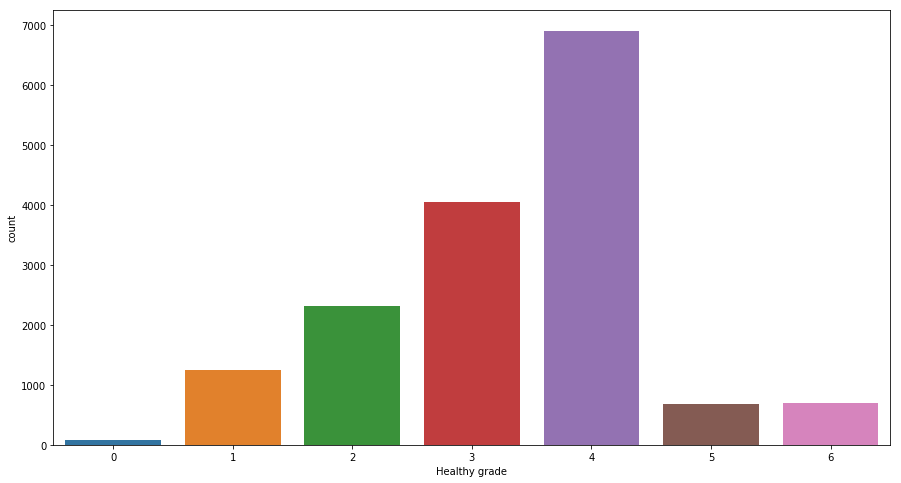

In [147]:
plt.figure(figsize=(15,8))
# full_set_test1['Healthy grade'] = full_set_test1['Healthy grade'].astype(int)
unhealthy = full_set_test1[full_set_test1['Healthy grade'] <= 3]
healthy = full_set_test1[full_set_test1['Healthy grade'] > 3]
sns.countplot(x='Healthy grade', data=full_set_test1)
print('healthy: ', float(healthy['Healthy grade'].count())/float(full_set_test1['Healthy grade'].count()))
print('unhealthy', float(unhealthy['Healthy grade'].count())/float(full_set_test1['Healthy grade'].count())) 

### Number of unhealthy recipes
After establishing that recipes with 0-2 nutrients, i.e. grade 4-6, exceeding the recommended daily value are considere healthy and the ones with 3-6, i.e. below grade of 4, are considered unhealthy, we give the following analysis.

From the above graph we can conclude that the majority of the recipes exceeds only 2 of the 6 nutrients present utilized in this analysis with a health grade of 4. We can also notice that there are more unhealthier recipes (4-6 nutrients exceeding the daily value) than there are of very healthy ones (0-2 of the nutrients exceeding the daily recommended values). It can noted as well how there's a very slim number of recipes that does exceeds the daily values for each nutrient.

We can then say that a little over half of the recipes are somewhat healthy or healthy with 51% of the total amount of recipes falling into this category, while the remaining 49% can be considered healthy.

In [151]:
pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['Healthy grade'])
print('Rating vs Healthy:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['protein healthy?'])
print('Rating vs Protein:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['fat healthy?'])
print('Rating vs Fat:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['carbs healthy?'])
print('Rating vs Carbs:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['cholesterol healthy?'])
print('Rating vs Cholesterol:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['sodium healthy?'])
print('Rating vs Sodium:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['fiber healthy?'])
print('Rating vs Fiber:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['protein'], full_set_test1['Healthy grade'])
print('Protein vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['fat'], full_set_test1['Healthy grade'])
print('Fat vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['totalcarbs'], full_set_test1['Healthy grade'])
print('Carbs vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['cholesterol'], full_set_test1['Healthy grade'])
print('Cholesterol vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['sodium'], full_set_test1['Healthy grade'])
print('Sodium vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['fiber'], full_set_test1['Healthy grade'])
print('Fiber  vs Healthy Grade:', round(pearson_corr,3))

('Rating vs Healthy:', -0.037)
('Rating vs Protein:', -0.006)
('Rating vs Fat:', -0.026)
('Rating vs Carbs:', 0.015)
('Rating vs Cholesterol:', 0.0)
('Rating vs Sodium:', -0.028)
('Rating vs Fiber:', -0.051)
('Protein vs Healthy Grade:', -0.61)
('Fat vs Healthy Grade:', -0.59)
('Carbs vs Healthy Grade:', -0.223)
('Cholesterol vs Healthy Grade:', -0.536)
('Sodium vs Healthy Grade:', -0.154)
('Fiber  vs Healthy Grade:', -0.147)


### Combining nutrients and health grades

In [154]:

nutri_comb_set = full_set_test1.copy()
cols = list(nutri_comb_set.columns)
cols.remove('rating')
cols.remove('protein healthy?')
cols.remove('fat healthy?')
cols.remove('carbs healthy?')
cols.remove('cholesterol healthy?')
cols.remove('sodium healthy?')
cols.remove('fiber healthy?')
cols.remove('Healthy grade')

new_comb_list = list(itertools.combinations(cols, 2))

for comb in new_comb_list:

    col = ' and '.join(comb)
    nutri_comb_set[col] = nutri_comb_set[comb[0]] *nutri_comb_set[comb[1]]
    pearson_corr, _ = pearsonr(full_set_test1['rating'], nutri_comb_set[col])
    if ((pearson_corr >= 0.15) | (pearson_corr <= -0.15)):
        print('Rating vs ', col , round(pearson_corr,3), '\n')
    pearson_corr, _ = pearsonr(full_set_test1['Healthy grade'], nutri_comb_set[col])
    if ((pearson_corr >= 0.15) | (pearson_corr <= -0.15)):
        print('Health Grade vs ', col , round(pearson_corr,3), '\n')

('Health Grade vs ', 'totalcarbs and protein', -0.194, '\n')
('Health Grade vs ', 'totalcarbs and cholesterol', -0.156, '\n')
('Health Grade vs ', 'totalcarbs and fat', -0.173, '\n')
('Health Grade vs ', 'fiber and cholesterol', -0.178, '\n')
('Health Grade vs ', 'fiber and fat', -0.162, '\n')
('Health Grade vs ', 'servings and protein', -0.416, '\n')
('Health Grade vs ', 'servings and cholesterol', -0.381, '\n')
('Health Grade vs ', 'servings and fat', -0.368, '\n')
('Health Grade vs ', 'sodium and fat', -0.151, '\n')
('Health Grade vs ', 'protein and cholesterol', -0.188, '\n')
('Health Grade vs ', 'protein and fat', -0.186, '\n')
('Health Grade vs ', 'cholesterol and fat', -0.152, '\n')


Above we can see relevant correlations between the health grade and other features in our set. We set a cutoff at +/-0.15 to highlight the most important relationships.

Among the strongest correlations we see the ones between the health grade and the combinations of servings/protein, servings/cholesterol, and servings/fat. It displays as a negative correlations, which shows us that the more servings and the higher amount of protein/fat/cholesterol in a recipe respectively, can lead to a lower health grade. This in turn means that a higher number of nutrients exceeds the recommended daily values. 

We have some other negative correlations that are, though, less strong compared to the above mentioned ones. Among these we see that the combinations of protein/fat, protein/cholesterol, protein/carbs, fat/cholesterol, fat/sodium, fat/carbs, fat/fiber, cholesterol/carbs, cholesterol/fiber, are more likely to generate a lower health grade for the group of recipes. 

## Graph based analysis

In [ ]:
temp_df = dataset.copy()

In [ ]:
recipe_names = temp_df.name.unique().tolist()

In [ ]:
recipe_enumeration = {}
i = 0
for name in recipe_names:
    recipe_enumeration[name] = i
    i = i + 1

In [ ]:
inv_map = {v: k for k, v in recipe_enumeration.iteritems()}

In [ ]:
N = len(recipe_enumeration.keys())
matrix = np.zeros((N,N))

In [ ]:
recipe_recommendation = temp_df[['name','recommendations']].values
recipe_rating = temp_df[['name','rating']].values

In [ ]:
recipe_mapping = {}
for recipe in recipe_recommendation:
    recipe_mapping[recipe[0]] = recipe[1]

In [ ]:
rating_mapping = {}
for recipe in recipe_rating:
    rating_mapping[recipe[0]] = recipe[1]

In [ ]:
node_degrees = []

In [ ]:
for recipe_name in recipe_mapping.keys():
    
    index_recipe = recipe_enumeration[recipe_name]
    node_degrees.append(len(recipe_mapping[recipe_name]))
    for other_recipe in recipe_mapping[recipe_name]:
        other_index = recipe_enumeration[other_recipe]
        matrix[index_recipe][other_index] = 1

In [ ]:
unique_degree =  np.unique(node_degrees)

In [ ]:
resulting_dict = {}
for deg in unique_degree:
    for rating in range(1,6):
        if deg>0:
            resulting_dict[(deg,rating)] = {}

In [ ]:
for deg in unique_degree:
    for rating in range(1,6):
        for sub_rating in range(1,6):
            if deg>0:
                resulting_dict[(deg,rating)][sub_rating] = 0

In [ ]:
for i in range(0,len(node_degrees)):
    
    if node_degrees[i] > 0:
        
        this_rating  = rating_mapping[inv_map[i]]
        recipes = np.where(matrix[i,:] > 0)[0].tolist()
        degree = node_degrees[i]
        for index in recipes:
                n = inv_map[index]
                rating_n = rating_mapping[n]
                resulting_dict[(degree,this_rating)][rating_n] +=1

In [ ]:
z = pd.DataFrame(resulting_dict).T

In [ ]:
z.plot.bar()

Common ingredients

In [ ]:
def flatten_ingredients(ingred_list):
    init_list = ingred_list[0]
    res = []
    for ingred in init_list:
        res.append(ingred)
    return res

In [ ]:
def count_common_ingredients(recipe_a_ingredlist,recipe_b_ingredlist):
    
    combined_ingreds = recipe_a_ingredlist + recipe_b_ingredlist
    ingredient_count = [(i,combined_ingreds.count(i)) for i in combined_ingreds]
    repeated_ingreds = list(filter(lambda x : x[1] > 1,ingredient_count))
    return len(repeated_ingreds)
    

In [ ]:
def transfrom_data_into_dict(input_data):
    
    recipe_to_ingred = {}
    for recipe in input_data:
        recipe_to_ingred[recipe[0]] = recipe[1]
    return recipe_to_ingred

In [ ]:
import time
def construct_graph(recipe_to_ingredients):
    
    n = len(recipe_to_ingredients.keys())
    matrix = np.zeros((n,n))
    
    for i in range(0,matrix.shape[0]):
        for j in range(0,matrix.shape[1]):
        
            if i<j:
                
                recipe_n = inv_map[i]
                other_n  = inv_map[j]
                
                common_elements = count_common_ingredients(recipe_to_ingredients[recipe_n],\
                                                           recipe_to_ingredients[other_n])

                matrix[i][j] = common_elements
                matrix[j][i] = common_elements
    
    return matrix

In [ ]:
temp_df = dataset.copy()

In [ ]:
temp_df.ingredients_y = temp_df.ingredients_y.apply(lambda x : flatten_ingredients(x))

In [ ]:
temp_recipe_ingred_df = temp_df[['name','ingredients_y']]

In [ ]:
temp_recipe_ingred_df = temp_recipe_ingred_df.groupby('name')['ingredients_y'].first()

In [ ]:
temp_recipe_ingred_df = temp_recipe_ingred_df.to_frame()
temp_recipe_ingred_df = temp_recipe_ingred_df.reset_index()

In [ ]:
recipe_to_ingred = transfrom_data_into_dict(temp_recipe_ingred_df.values.tolist())

In [ ]:
graph = construct_graph(recipe_to_ingred)

In [ ]:
node_degree_ingred = np.count_nonzero(matrix,axis=0)

In [ ]:
unique_degree_ingred =  np.unique(node_degree_ingred)

In [ ]:
resulting_dict_ingred = {}
for deg in unique_degree_ingred:
    for rating in range(1,6):
        if deg>0:
            resulting_dict_ingred[(deg,rating)] = {}

In [ ]:
for deg in unique_degree_ingred:
    for rating in range(1,6):
        for sub_rating in range(1,6):
            if deg>0:
                resulting_dict_ingred[(deg,rating)][sub_rating] = 0

In [ ]:
for i in range(0,len(node_degree_ingred)):
    
    if node_degree_ingred[i] > 0:
        
        this_rating  = rating_mapping[inv_map[i]]
        recipes = np.where(graph[i,:] > 0)[0].tolist()
        degree = node_degree_ingred[i]
        for index in recipes:
                n = inv_map[index]
                rating_n = rating_mapping[n]
                resulting_dict_ingred[(degree,this_rating)][rating_n] +=1

In [ ]:
z = pd.DataFrame(resulting_dict_ingred).T

In [ ]:
z.plot.bar()

In [ ]:
graph2 = np.loadtxt('grap')